In [1]:
import sns_toolbox
from sns_toolbox.networks import Network
from sns_toolbox.renderer import render
from sns_toolbox.neurons import NonSpikingNeuron
from sns_toolbox.connections import NonSpikingSynapse

import torch
import torch.nn as nn
from conductance_network import GsynModule, ConductanceLayerMulti, ConductanceNetwork

In [2]:
# Define the number of neurons
num_neurons = 2
num_layers = 3


In [3]:
# Create a network
layers = []
dt = 0.01 * torch.ones(num_neurons, dtype=torch.double)
C_mem = torch.ones(num_neurons, dtype=torch.double)
G_mem = torch.ones(num_neurons, dtype=torch.double)
b_mem = torch.zeros(num_neurons, dtype=torch.double)
self_Esyn = torch.zeros((num_neurons,num_neurons), dtype=torch.double)
self_Gysn = lambda _: torch.zeros((num_neurons,num_neurons), dtype=torch.double)

layers = [
    ConductanceLayerMulti(
        n = num_neurons,
        n_prev= num_neurons,
        dt = dt.clone(),
        C_mem = C_mem.clone(),
        G_mem = G_mem.clone(),
        b_mem = b_mem.clone(),
        Esyn_self=self_Esyn.clone(),
        Gsyn_self=self_Gysn,
        Gsyn_prev=lambda x: torch.clamp(x,min=0,max=1),
        Esyn_prev = torch.eye(num_neurons, dtype=torch.double)
    )
    for i in range(num_layers)
]
layers[0].is_first_layer = True


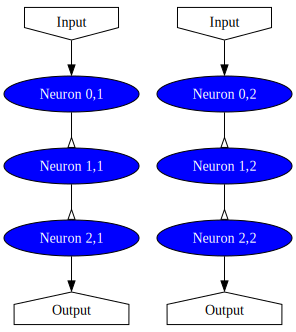

In [8]:
neuron = NonSpikingNeuron(name='Neuron',  # Name displayed in a render of the network
                               color='white',  # Fill color for the rendered neuron
                               membrane_capacitance=1.0,  # Membrane capacitance in nF
                               membrane_conductance=1.0,  # Membrane conductance in uS
                               bias=0.0)               # Tonic ap
synapse = NonSpikingSynapse(e_hi=1.0,reversal_potential=1.0) # make an inhibitory synapse

fully_connected_network = Network(name='Fully Connected Network')
for i in range(num_layers):
    fully_connected_network.add_neuron(neuron, name=f'Neuron {i},1', color='blue')
    fully_connected_network.add_neuron(neuron, name=f'Neuron {i},2', color='blue')

fully_connected_network.add_input(f'Neuron 0,1')
fully_connected_network.add_input(f'Neuron 0,2')

for i in range(num_layers-1):
    fully_connected_network.add_connection(synapse,f"Neuron {i},1",f"Neuron {i+1},1")
    fully_connected_network.add_connection(synapse,f"Neuron {i},2",f"Neuron {i+1},2")

fully_connected_network.add_output(f'Neuron {num_layers-1},1')
fully_connected_network.add_output(f'Neuron {num_layers-1},2')


render(fully_connected_network)


In [9]:

fully_connected_net = fully_connected_network.compile(dt=0.01)
layered_network = ConductanceNetwork(layers)
input = torch.ones(num_neurons, dtype=torch.double)
# run networks
full_outs = []
layered_outs = []
for i in range(5):
    full_outs.append(fully_connected_net(input.detach().numpy()))
    print(f"full:\t{full_outs[-1]}")
    layered_outs.append(layered_network(input))
    print(f"layered:\t{layered_outs[-1]}")
    
    

full:	[0. 0.]
layered:	tensor([0., 0.], dtype=torch.float64, grad_fn=<AddBackward0>)
full:	[0. 0.]
layered:	tensor([0., 0.], dtype=torch.float64, grad_fn=<AddBackward0>)
full:	[1.e-06 1.e-06]
layered:	tensor([1.0000e-06, 1.0000e-06], dtype=torch.float64, grad_fn=<AddBackward0>)
full:	[3.96979802e-06 3.96979802e-06]
layered:	tensor([3.9496e-06, 3.9496e-06], dtype=torch.float64, grad_fn=<AddBackward0>)
full:	[9.8492945e-06 9.8492945e-06]
layered:	tensor([9.7492e-06, 9.7492e-06], dtype=torch.float64, grad_fn=<AddBackward0>)


In [7]:
print(fully_connected_net.del_e)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [40.  0.  0.  0.  0.  0.]
 [ 0. 40.  0.  0.  0.  0.]
 [ 0.  0. 40.  0.  0.  0.]
 [ 0.  0.  0. 40.  0.  0.]]
